In [152]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import pandas as pd

In [10]:
# Fitts' law
def fitts(d, w, a=0.81, b= 1.12):
    """Fitts' law"""
    return a + b * (math.log2( 2 * d / w))

## Example data

In [130]:
data = {"W" : [100, 150, 220, 110, 40],
        "D" : [300, 50, 100, 200, 250],
       "time" : [3.36, 1.08, 1.16, 3.07, 4.12]}

df = pd.DataFrame(data)

df

,W,D,time
0,100,300,3.36
1,150,50,1.08
2,220,100,1.16
3,110,200,3.07
4,40,250,4.12


# Direct Calculation (thorugh Linear Regression)

In [129]:
# Loss
    
def loss(a, b):
    """Loss function"""
    Ypred = [fitts(x[0], x[1], a=a, b=b) for x in zip(df.D, df.W)]
    Yobs = df.time
    return np.sum((Ypred - Yobs)**2)

In [131]:
# New feature
X = np.log2(2 * df.D / df.W)

# Matrix algebra
X = np.array(X)
ones = np.ones((5, 1))

X.resize(5, 1)
X = np.dstack((ones, X)).squeeze()

Y = np.array(df.time)
Y.resize(5,1)

In [128]:
a_star, b_star = la.inv(X.T.dot(X)).dot(X.T).dot(Y)
print("a = %.4f, b= %.4f" % (a_star, b_star))

a = 1.4438, b= 0.7560


In [138]:
loss(float(a_star), float(b_star))

0.09370449541006619

# Grid Search

/tmp/ipykernel_14821/3005109790.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(A, B, np.sqrt(grid))


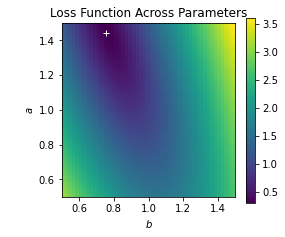

In [176]:


A = np.linspace(0.5, 1.5)
B = np.linspace(0.5, 1.5)
grid = np.zeros((A.size, B.size))

for i, a in enumerate(A):
    for j, b in enumerate(B):
        grid[i,j] = loss(a, b)
        

fig = plt.figure(figsize=(5, 3.2))

ax = fig.add_subplot(111)
ax.set_title('Loss Function Across Parameters')
X,Y = np.meshgrid(A, B)
plt.pcolormesh(A, B, np.sqrt(grid))
plt.plot(b_star, a_star, "+", color="white")
ax.set_aspect('equal')
ax.set_xlabel("$b$")
ax.set_ylabel("$a$")

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

#fig.tight_layout()
plt.savefig("fitts_grid.png")
plt.show()


# Optimization

/tmp/ipykernel_14821/1094766342.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(A, B, np.sqrt(grid))


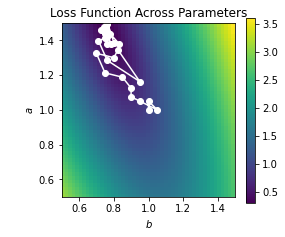

In [175]:
global path 
path = []
def vloss(vec):
    """Vector form of loss function"""
    global path
    path += [vec]
    return loss(vec[0], vec[1])

opt.minimize(vloss, np.array([1, 1]), method="Nelder-Mead")

fig = plt.figure(figsize=(5, 3.2))

ax = fig.add_subplot(111)
ax.set_title('Loss Function Across Parameters')
plt.pcolormesh(A, B, np.sqrt(grid))
plt.plot([x[1] for x in path], [x[0] for x in path], "-o", color="white")
ax.set_aspect('equal')
ax.set_xlabel("$b$")
ax.set_ylabel("$a$")
ax.set_ylim(0.5, 1.5)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

#fig.tight_layout()
plt.savefig("fitts_optimize.png")
plt.show()

